# データ前処理 よりよいトレーニングセットの構築

## 欠測データへの対処

In [1]:
import pandas as pd
from io import StringIO

In [2]:
# CSV: Comma-Separated Values
csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

In [3]:
df = pd.read_csv(StringIO(csv_data))

In [4]:
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [8]:
# 欠測値をカウント
# 列（特徴量）ごと
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [14]:
# 行（サンプル）ごと
df.isnull().sum(1)

0    0
1    1
2    1
dtype: int64

In [16]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

### 欠測値を持つサンプル／特徴量を取り除く

In [19]:
# 欠測値を含む行を削除
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [20]:
# 列
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [21]:
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


欠測値を削除することにはいくつか明らかな問題がある。

* サンプルを削除しすぎるとnが減って信頼性が減る
* 特徴量の列を削除しすぎると、識別に有用な特徴量が失われる

他の欠損値への対処法として、**補間法**がある。

### 欠損値を補間する

最も一般的な補間法： **平均値補間**

In [24]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [25]:
imr = imr.fit(df)

In [26]:
imr

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [27]:
imputed_data = imr.transform(df.values)

In [28]:
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

### scikit-learnの推定器API

scikit-learnの変換器（transformer）クラス：fitとtransformの2つの基本的なメソッドを持つ

* fit: parametersを学習
* transform: parametersに基づいてデータを変換

推定器：変換器クラスと類似。predictメソッドを持つ。

## カテゴリデータの処理

名義データと順序データ

In [29]:
import pandas as pd
df = pd.DataFrame([
        ['green', 'M', 10.1, 'class1'],
        ['red', 'L', '13.5', 'class2'],
        ['blue', 'XL', 15.3, 'class1'],
    ])

In [30]:
df.columns = ['color', 'size', 'price', 'classlabel']

In [31]:
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### 順序特徴量のマッピング

In [32]:
# 辞書を生成
size_mapping = {'XL':3, 'L':2, 'M':1}

In [33]:
df['size'] = df['size'].map(size_mapping)

In [34]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [35]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}

In [36]:
size_mapping

{'L': 2, 'M': 1, 'XL': 3}

In [38]:
size_mapping.items()

dict_items([('M', 1), ('XL', 3), ('L', 2)])

In [39]:
inv_size_mapping

{1: 'M', 2: 'L', 3: 'XL'}

In [40]:
df['size'] = df['size'].map(inv_size_mapping)

In [41]:
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### クラスラベルのエンコーディング

In [42]:
import numpy as np

class_mapping = {label:idx for idx, label in enumerate(np.unique(df['classlabel']))}

In [43]:
class_mapping

{'class1': 0, 'class2': 1}

In [44]:
df['classlabel'] = df['classlabel'].map(class_mapping)

In [45]:
df

,color,size,price,classlabel
0,green,M,10.1,0
1,red,L,13.5,1
2,blue,XL,15.3,0


In [46]:
inv_class_mapping = {idx:label for label, idx in class_mapping.items()}

In [47]:
inv_class_mapping

{0: 'class1', 1: 'class2'}

In [48]:
df['classlabel'] = df['classlabel'].map(inv_class_mapping)

In [49]:
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [50]:
df['classlabel']

0    class1
1    class2
2    class1
Name: classlabel, dtype: object

In [51]:
from sklearn.preprocessing import LabelEncoder

In [52]:
class_le = LabelEncoder()

In [54]:
y = class_le.fit_transform(df['classlabel'].values)

In [55]:
y

array([0, 1, 0])

In [56]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### 名義特徴量でのone-hotエンコーディング

In [70]:
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [68]:
df[['color', 'size', 'price']].values

array([['green', 'M', 10.1],
       ['red', 'L', '13.5'],
       ['blue', 'XL', 15.3]], dtype=object)

In [71]:
X = df[['color', 'size', 'price']].values

In [60]:
color_le = LabelEncoder()

In [61]:
X[:, 0] = color_le.fit_transform(X[:, 0])

In [62]:
X

array([[1, 'M', 10.1],
       [2, 'L', '13.5'],
       [0, 'XL', 15.3]], dtype=object)

このままこのデータを分類器にぶちこむのはよろしくない。本来ない順序関係を想定。

**one-hot encoding**: 一つ一つに対しダミー変数を用いる

In [63]:
from sklearn.preprocessing import OneHotEncoder

In [72]:
ohe = OneHotEncoder(categorical_features=[0])

In [74]:
# なぜうまくいかない？
ohe.fit_transform(X).toarray()

In [75]:
pd.get_dummies(df[['price', 'color', 'size']])

,price_10.1,price_15.3,price_13.5,color_blue,color_green,color_red,size_L,size_M,size_XL
0,1,0,0,0,1,0,0,1,0
1,0,0,1,0,0,1,1,0,0
2,0,1,0,1,0,0,0,0,1


## データセットをトレーニングデータセットとテストデータセットに分割する

In [76]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [78]:
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [79]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 特徴量の尺度を揃える

**feature scaling**: 決定木・ランダムフォレスト以外の多くのアルゴリズムにとって必須

* 正規化：normalization: [0,1]の範囲に
* 標準化：standardization:

In [81]:
#min-max scaling
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [88]:
# standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## 有益な特徴量の選択

テストデータセットよりトレーニングデータセットのほうがモデルのパフォーマンスがはるかによい→過学習

原因：与えられたトレーニングデータセットに対してモデルが複雑すぎる

対処法：

* データを集める
* 正則化
* モデルをより単純に（パラメータを減らす）
* データの次元を減らす

### L1正則化による疎な解

In [86]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1)

lr.fit(X_train_std, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [89]:
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


In [90]:
lr.intercept_

array([-0.3838071 , -0.15813161, -0.70036646])

In [91]:
lr.coef_

array([[ 0.27991192,  0.        ,  0.        , -0.0279123 ,  0.        ,
         0.        ,  0.70990688,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23661229],
       [-0.6438086 , -0.06887149, -0.05718242,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92723607,
         0.05983133,  0.        , -0.37093855],
       [ 0.        ,  0.06134982,  0.        ,  0.        ,  0.        ,
         0.        , -0.63690834,  0.        ,  0.        ,  0.49845629,
        -0.35822804, -0.57019903,  0.        ]])

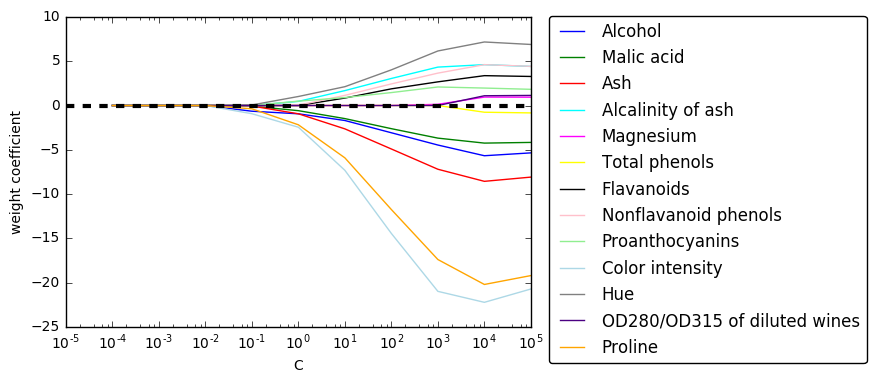

In [98]:
# 正則化パスのグラフ化
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []

for c in np.arange(-4,6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

#shapeは要素数
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1], color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)

plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')

plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)

plt.show()

### 逐次特徴選択アルゴリズム

次元選択には２種類ある

* 特徴選択：特徴量の一部を選択
    - 計算効率の改善
    - 汎化誤差の削減　特に正則化をサポートしていないアルゴリズムに対し有効
    - SBS(Sequential Backward Selection): 貪欲探索の一種
* 特徴抽出：特徴量の集合から新たな特徴部分空間を生成（情報を抽出）

In [113]:
# SBSの実装

from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]

        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)

        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [114]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier()
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

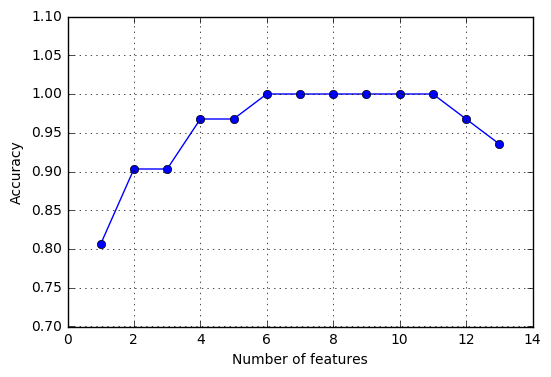

In [116]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [117]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Total phenols', 'Nonflavanoid phenols',
       'Color intensity'],
      dtype='object')


### ランダムフォレストで特徴量の重要度にアクセス